# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/assignments/'

Mounted at /content/drive


In [206]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sns
import os
import requests
from os import walk
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.backend import epsilon

### Change directory

In [12]:
os.getcwd()

'/content'

In [13]:
os.chdir('/content/drive/MyDrive/assignments')

In [14]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/raccoon-166.jpg  
  inflating: images/raccoon-153.jpg  
  inflating: images/raccoon-141.jpg  
  inflating: images/raccoon-17.jpg   
  inflating: images/raccoon-79.jpg   
  inflating: images/raccoon-78.jpg   
  inflating: images/raccoon-84.jpg   
  inflating: images/raccoon-54.jpg   
  inflating: images/raccoon-154.jpg  
  inflating: images/raccoon-187.jpg  
  inflating: images/raccoon-176.jpg  
  inflating: images/raccoon-57.jpg   
  inflating: images/raccoon-137.jpg  
  inflating: images/raccoon-124.jpg  
  inflating: images/raccoon-167.jpg  
  inflating: images/raccoon-151.jpg  
  inflating: images/raccoon-91.jpg   
  inflating: images/raccoon-111.jpg  
  inflating: images/raccoon-199.jpg  
  inflating: images/raccoon-186.jpg  
  inflating: images/raccoon-53.jpg   
  inflating: images/raccoon-114.jpg  
  inflating: images/raccoon-75.jpg   
  inflating: images/raccoon-104.jpg  
  inflating: images/raccoon-64.jpg   
  inflat

### Load the training data from train.csv file

In [92]:
 train = pd.read_csv(project_path + 'train_labels.csv')

In [93]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [94]:
train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [95]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [96]:
train['xmin'][0]

95

In [97]:
# path = []
# coords = []
# for index, row in train.index:
#   path.append(train['filename'][index])
#   coords.append([train['xmin'][index]*IMAGE_SIZE/train['width'][index],
#                 train['ymin'][index]*IMAGE_SIZE/train['height'][index],
#                 train['xmax'][index]*IMAGE_SIZE/train['width'][index],
#                 train['ymax'][index]*IMAGE_SIZE/train['height'][index]])

In [231]:
path = []
coords = []
for i, row in train.iterrows():
  filename,	width,	height,	class_,	xmin,	ymin,	xmax,	ymax = row
  xmin = xmin*IMAGE_SIZE/width
  ymin = ymin*IMAGE_SIZE/height
  xmax = xmax*IMAGE_SIZE/width
  ymax = ymax*IMAGE_SIZE/height
  path.append(filename)
  coords.append([xmin, ymin, xmax, ymax])

In [232]:
coords = np.array(coords)

In [233]:
coords.shape

(173, 4)

Alternate way to read the csv

In [207]:
# import csv

In [217]:
# coords_1 = []
# paths_1 = []
# with open('train_labels.csv', 'r') as csvfile:
#   read_l = csv.reader(csvfile, delimiter=',')
#   next(read_l)

#   for i, row in enumerate(read_l):
#     xmin = int(row[4])*IMAGE_SIZE/int(row[1])
#     xmax = int(row[-2])*IMAGE_SIZE/int(row[1])
#     ymin = int(row[5])*IMAGE_SIZE/int(row[2])
#     ymax = int(row[-1])*IMAGE_SIZE/int(row[2])
#     coord=[xmin, ymin, xmax, ymax]
#     coords_1.append(coord)
#     paths_1.append(row[0])

In [221]:
# coords_1 = np.array(coords_1)
# coords_1.shape

(173, 4)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [111]:
 batch_images = np.zeros((len(path), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

In [112]:
 for i, f in enumerate(path):
      img = Image.open('images/' + f) # Read image
      img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
      img = img.convert('RGB')
      batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
      # batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
      img.close()

In [113]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [123]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0)

for layer in model.layers:
    layer.trainable = False

x = model.layers[-1].output # Add output to the last layer
x = Conv2D(4, kernel_size=4)(x)
x = Reshape((4,))(x)

model= Model(inputs = model.input, outputs=x)

In [124]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

### Define a custom loss function IoU which calculates Intersection Over Union

In [142]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [143]:
model.compile(loss="mse", optimizer="Adam", metrics=[IoU]) # Regression loss is MSE

In [146]:
model.fit(x=batch_images, y=coords, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
6/6 [==============================] - 0s 51ms/step - loss: 2428.4890 - IoU: 0.1636
Epoch 2/30
6/6 [==============================] - 0s 15ms/step - loss: 434.1303 - IoU: 0.5267
Epoch 3/30
6/6 [==============================] - 0s 13ms/step - loss: 541.6721 - IoU: 0.5680
Epoch 4/30
6/6 [==============================] - 0s 14ms/step - loss: 447.5225 - IoU: 0.6097
Epoch 5/30
6/6 [==============================] - 0s 13ms/step - loss: 217.2583 - IoU: 0.6687
Epoch 6/30
6/6 [==============================] - 0s 14ms/step - loss: 190.5129 - IoU: 0.6541
Epoch 7/30
6/6 [==============================] - 0s 14ms/step - loss: 167.7480 - IoU: 0.6913
Epoch 8/30
6/6 [==============================] - 0s 13ms/step - loss: 122.3338 - IoU: 0.7355
Epoch 9/30
6/6 [==============================] - 0s 14ms/step - loss: 108.1069 - IoU: 0.7704
Epoch 10/30
6/6 [==============================] - 0s 13ms/step - loss: 101.3645 - IoU: 0.7786
Epoch 11/30
6/6 [==============================] - 0s 14ms

### Pick a test image from the given data

In [198]:
# im = Image.open(requests.get('https://static3.bigstockphoto.com/5/4/2/large2/2450455.jpg', stream=True).raw)
im = Image.open(requests.get('https://static1.bigstockphoto.com/1/9/8/large2/89151176.jpg', stream=True).raw)

In [199]:
image_height = im.height
image_width = im.width

In [200]:
image_height

470

In [201]:
image_width

299

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [202]:
imResized = im.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
imResized = imResized.convert('RGB')
im_val = preprocess_input(np.array(imResized, dtype=np.float32))

In [203]:
im_val.shape

(128, 128, 3)

### Predict the coordinates of the bounding box for the given test image

In [204]:
region = model.predict(np.array([im_val]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

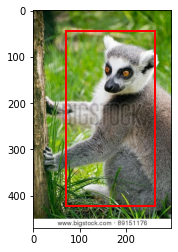

In [205]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()